In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Spoiler Detection/LM-BFF"
%ls

/content/drive/MyDrive/Spoiler Detection/LM-BFF
auto_label_mapping/        log.lock
auto_template/             new_env/
average_logits.py          old_ensemble_predict_results/
copy_ensemble_predicts.sh  README.md
count_tokens.ipynb         requirements.txt
count_tokens.py            result/
data/                      run_experiment.sh
discord_log                run.ipynb
eda.ipynb                  run_multiple.sh
ensemble_predict_results/  run.py
ensemble.sh                spoilers_auto_label_mapping/
env/                       spoilers_auto_template/
evaluate.ipynb             src/
evaluate.sh                template_search.sh
figs/                      tmp.txt
label_search.sh            tools/
LICENSE                    train_individual.sh
log                        uncertain_log


In [ ]:
# !source env/bin/activate; python -m pip install --upgrade pip
# !source env/bin/activate; pip install torchmetrics
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 9.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from torchmetrics.functional import auroc, precision_recall_curve, fbeta_score, accuracy
from torchmetrics.functional import precision as precision_score
from torchmetrics.functional import recall as recall_score
import torch.nn.functional as F
import torch

In [24]:
# Per episode model
# all_preds, all_labels = [], []

DEV_PATH = 'data/k-shot/spoilers/binary_v1.0/3615-21/dev.csv'
DEV_LOGITS = 'result/stuffed_v1.0_batch32/spoilers--1--1-eval.npy'
# DEV_LOGITS = 'ensemble_predict_results/prompt/val/avg_logits.npy'

TEST_PATH = 'data/k-shot/spoilers/binary_v1.0/3615-21/test.csv'
TEST_LOGITS = 'result/stuffed_v1.0_batch32/spoilers--1--1-test.npy'
# TEST_LOGITS = 'ensemble_predict_results/prompt/test/avg_logits.npy'

In [25]:
# Select best threshold based on validation set
valset = pd.read_csv(DEV_PATH, header=None).values
labels = torch.tensor(valset[:, 0].astype(int))

logits = np.load(DEV_LOGITS)
logits = torch.tensor(logits)
pos_score = F.softmax(logits, dim=1)[:, 1]

print('AUROC: {}'.format(auroc(pos_score, labels, task='binary')))

precision, recall, thresholds = precision_recall_curve(pos_score, labels, task='binary', num_classes=1)

scores = [fbeta_score(pos_score, labels, task='binary', threshold=threshold.item(), num_classes=1) for threshold in thresholds]
idx = np.argmax(scores)

SELECTED_THRESHOLD = thresholds[idx].item()

idx, scores[idx].item(), SELECTED_THRESHOLD

AUROC: 0.9170293211936951


(1579, 0.7996280789375305, 0.544035017490387)

In [26]:
testset = pd.read_csv(TEST_PATH, header=None).values
labels = torch.tensor(testset[:, 0].astype(int))

logits = np.load(TEST_LOGITS)
logits = torch.tensor(logits)
scores = F.softmax(logits, dim=1)
pos_score = scores[:, 1]
print('Threshold-based classifier:\n')
print('AUROC: {}'.format(auroc(pos_score, labels, task='binary')))

precision, recall, thresholds = precision_recall_curve(pos_score, labels, task='binary', num_classes=1)

print('F1: {}'.format(fbeta_score(pos_score, labels, task='binary', beta=1.0, threshold=SELECTED_THRESHOLD, num_classes=1).item()))
print('Precision: {}'.format(precision_score(pos_score, labels, task='binary', threshold=SELECTED_THRESHOLD, num_classes=1).item()))
print('Recall: {}'.format(recall_score(pos_score, labels, task='binary', threshold=SELECTED_THRESHOLD, num_classes=1).item()))
print('Accuracy: {}'.format(accuracy(pos_score, labels, task='binary', threshold=SELECTED_THRESHOLD, num_classes=1).item()))

Threshold-based classifier:

AUROC: 0.9183703660964966
F1: 0.8082051277160645
Precision: 0.8157349824905396
Recall: 0.8008130192756653
Accuracy: 0.8306159377098083


In [ ]:
scores.argmax(dim=1)

tensor([0, 0, 1,  ..., 0, 1, 1])

In [ ]:
print('Argmax-based classifier:\n')
print('F1: {}'.format(fbeta_score(scores.argmax(dim=1), labels, task='binary', beta=1.0, num_classes=1).item()))
print('Precision: {}'.format(precision_score(scores.argmax(dim=1), labels, task='binary', num_classes=1).item()))
print('Recall: {}'.format(recall_score(scores.argmax(dim=1), labels, task='binary', num_classes=1).item()))
print('Accuracy: {}'.format(accuracy(scores.argmax(dim=1), labels, task='binary', num_classes=1).item()))

Argmax-based classifier:

F1: 0.8154761791229248
Precision: 0.7965116500854492
Recall: 0.8353658318519592
Accuracy: 0.83152174949646


Recall: 0.8617886304855347, Precision: 0.7737226486206055, Threshold: 0.42229151725769043


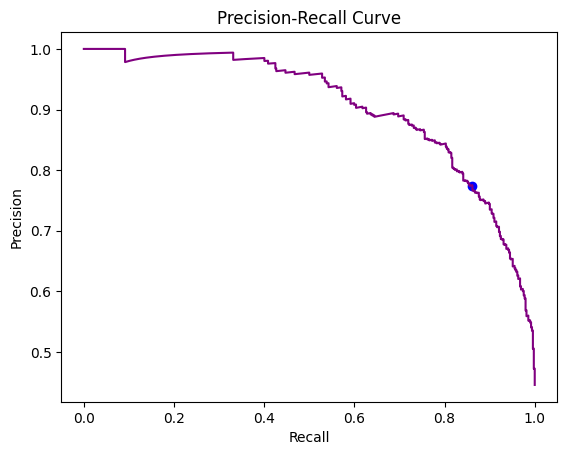

In [ ]:
import matplotlib.pyplot as plt
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

idx = (thresholds < SELECTED_THRESHOLD).sum() - 1
ax.scatter(recall[idx], precision[idx], color='blue')
print('Recall: {}, Precision: {}, Threshold: {}'.format(
    recall[idx], precision[idx], thresholds[idx]
))

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [ ]:
all_preds.append((pos_score > SELECTED_THRESHOLD).type(torch.int64))
all_labels.append(labels)

NameError: ignored

In [ ]:
print(len(all_preds))
print(len(all_labels))

11
11


In [ ]:
torch.cat(all_labels)

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
# Per episode model
print('AUROC: {}'.format(auroc(torch.cat(all_preds), torch.cat(all_labels), pos_label=1, num_classes=1)))
print('F1: {}'.format(fbeta_score(torch.cat(all_preds), torch.cat(all_labels), beta=1.0, num_classes=1, multiclass=False).item()))
print('Accuracy: {}'.format(accuracy(torch.cat(all_preds), torch.cat(all_labels), num_classes=1, multiclass=False).item()))

AUROC: 0.6866074800491333
F1: 0.6713070273399353
Accuracy: 0.8097015023231506


In [ ]:
# Set to argmax version instead of thresholding
pos_score = scores

In [ ]:
def get_predictions(probs, labels, threshold):
    if len(probs.shape) == 1:
        pred = probs > threshold
        print('Using threshold: {}'.format(threshold))
    elif len(probs.shape) == 2:
        pred = probs.argmax(dim=1)
        print('Using argmax')
    else:
        raise ValueError()
    TP = torch.logical_and(pred == 1, labels == 1).sum()
    FP = torch.logical_and(pred == 1, labels == 0).sum()
    TN = torch.logical_and(pred == 0, labels == 0).sum()
    FN = torch.logical_and(pred == 0, labels == 1).sum()
    print(TP / (TP + FP))

    return TP, FP, TN, FN

get_predictions(pos_score, labels, SELECTED_THRESHOLD)

Using threshold: 0.4239228665828705
tensor(0.7751)


(tensor(424), tensor(123), tensor(489), tensor(68))

In [ ]:
def get_improvement(pos_score, labels, threshold):
    TP, FP, TN, FN = get_predictions(pos_score, labels, threshold)
    print(TP.item(), FP.item(), TN.item(), FN.item())
    print('Positive class accuracy: {}'.format(TP / (TP + FN)))
    print('Negative class accuracy: {}'.format(TN / (TN + FP)))
    print('Cleanliness before: {}'.format(1 - labels.sum() / len(labels)))
    print('Cleanliness after: {}'.format(TN / (TN + FN)))
    print('Examples before: {}'.format(TP + FP + TN + FN))
    print('Examples left: {}'.format(TN + FN))

get_improvement(pos_score, labels, SELECTED_THRESHOLD)

Using threshold: 0.4239228665828705
tensor(0.7751)
424 123 489 68
Positive class accuracy: 0.8617886304855347
Negative class accuracy: 0.7990196347236633
Cleanliness before: 0.554347813129425
Cleanliness after: 0.8779174089431763
Examples before: 1104
Examples left: 557


In [ ]:
print(get_predictions(pos_score, labels, SELECTED_THRESHOLD))

if len(pos_score.shape) == 1:
    pred = pos_score > SELECTED_THRESHOLD
elif len(pos_score.shape) == 2:
    pred = pos_score.argmax(dim=1)
else:
    raise ValueError()
TP = torch.logical_and(pred == 1, labels == 1)
FP = torch.logical_and(pred == 1, labels == 0)
TN = torch.logical_and(pred == 0, labels == 0)
FN = torch.logical_and(pred == 0, labels == 1)

Using threshold: 0.6690308451652527
tensor(0.8109)
(tensor(386), tensor(90), tensor(522), tensor(106))


In [ ]:
metrics = [(TP, 'Irrelevants that will be thrown out:'),
           (FP, 'Relevants that will be sacrificed:'),
           (TN, 'Relevants that will be kept:'),
           (FN, 'Missed irrelevants:')]
def display_metric(metric):
    print(metric[1] + ' {}'.format(metric[0].sum()))
    print()
    lengths = []
    for idx in range(len(metric[0])):
        if metric[0][idx]:
            print('{}: \t {}'.format(idx, testset[idx][1]))
            lengths.append(len(testset[idx][1]))
    plt.hist(lengths, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
    print('mean: {}, median: {}, std: {}'.format(np.mean(lengths), np.median(lengths), np.std(lengths)))

Irrelevants that will be thrown out: 432

2: 	 damn, this should have been an entire season imo. Poor powder
3: 	 Brrrrrakamono I have read the manga. Obviously I will not be spoiling it
4: 	 So this is Primitive Technology: the Anime?
5: 	 Whats the end credit song of this episode?
6: 	 I'm starting to get the feeling Vaatu and Raava will combine again like before Wan severed them. They keep mentioning how their connection is critical to keeping the darkness out of the world and what would be better than keeping both Raava and Vaatu in the same body.
7: 	 Episode 1 karma all time record broken!!!
10: 	 I was a bit worried seeing these CGI cars but I see that hype for the manga was definitely worth it. This was so much fun and enjoyable, Eguchi is doing a good job but Atsumi Tanezaki may slowly become one of my favourite seiyuus. It also seems like during this busy IRL spring anime season I will be double spoiled with mixes of really good comedy with heartfelt moments by both Kaguya on

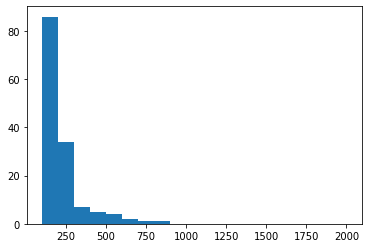

In [ ]:
display_metric(metrics[0]) # TP

Relevants that will be sacrificed: 157

9: 	 Something tells me, that Lin will handle delivering baby MUCH WORSE than Katara
11: 	 in Digibro's podcast, He mentioned how he thought the high production animation didn't really add anything to the work, unlike one Punch man. That wasn't an unfair assessment to make at the time. However, this episode is a turning point in the narrative showing us a bit of mob's psyche. The fights and consequently, all of mob's explosions stand in stark contrast to how we see mob otherwise, and the animation certainly helps emphasize that. The fight's in particular are very well choreographed and have a tremendously good sense of motion, even if they aren't as bombastic as OPM's fights, so that's where the decision to make it super well animated came from.
14: 	 I'll kill them allll!!! - Eren
23: 	 So, as far as I understand, does this mean all titan Eldians are related to Ymir? How did the 9 titans and pure titans sperate through the lineage?
50: 	 I’m gla

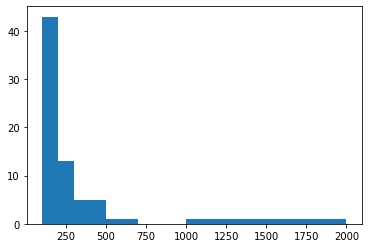

In [ ]:
display_metric(metrics[1]) # FP

Relevants that will be kept: 455

0: 	 Finally watched it. This episode was way better. I loved Jeans inner struggle to choose between the world and himself/future family. Is that Mikasa he was imagining being married to? I saw a scar on her cheek. Hange was kinda weird. She claims she isn't their superior and then says shes still the commander of the survey corps. She points that all the dead soldiers wouldnt agree with genocide but what about the yeagerist. Many of them were once cadets or in the new survey corps and they agreed with the rumbling why would all the dead soldiers who only knew that humanity lived within the walls fight for the rest of humanity which forced them in this situation, Kinda nitpicky but what I noticed. At 3:20 jean says they tried for years looking for answers. Years: the 4-year timeskip. At 7:57 Hange says they lived in the outside world. This basically comfirms that they tried diplomacy. The only reason hange would have a true reason to go would be to pre

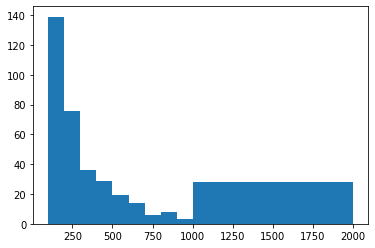

In [ ]:
display_metric(metrics[2]) # TN

Missed irrelevants: 60

16: 	 I see Toph making a mistake with "neutral jing" in the next episode... I still miss you Bumi <3
61: 	 Me seeing the village with 40 people. Cotton matte
62: 	 I never understood why they didn't just tie a rope to a jug and just throw the jug into the lake and put it out with the rope. They never really needed to get near the poison gas.
102: 	 i love that toph was back but i think she really overused the word "butt"
106: 	 SAO was sacrificed for Kaguya. Nice. This season won't be as fun as originally expected, but at least we'll get Money Wars: Kambe Daisuke vs Shinomiya Group
107: 	 I am just so happy my man Senku is back And best girl Kohaku
134: 	 I really don't understand the cause-effect chain that led to this moment. Why did Annie, Reiner and Bertolt attack in the first place? Because Marley needed the founding titan to increase their military power? I mean yeah Eldians first committed atrocities to the Marleyans, but then the Eldians took an oath of

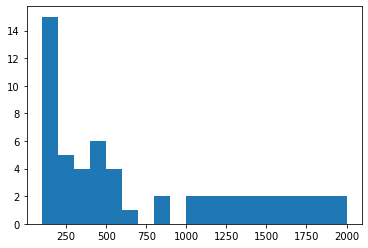

In [ ]:
display_metric(metrics[3]) # FN

Irrelevants
mean: 122.5020325203252, median: 72.5, std: 153.32717156650452


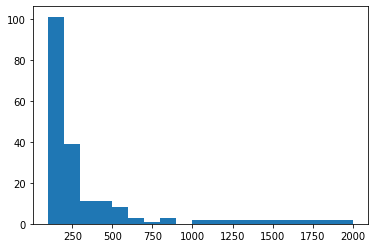

In [ ]:
relevant_lengths, irrelevant_lengths = [], []
for idx in range(len(labels)):
    if testset[idx][0]:
        irrelevant_lengths.append(len(testset[idx][1]))
    else:
        relevant_lengths.append(len(testset[idx][1]))
plt.hist(irrelevant_lengths, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
print('Irrelevants')
print('mean: {}, median: {}, std: {}'.format(np.mean(irrelevant_lengths), np.median(irrelevant_lengths), np.std(irrelevant_lengths)))

Relevants
mean: 302.08169934640523, median: 159.5, std: 430.33055753693975


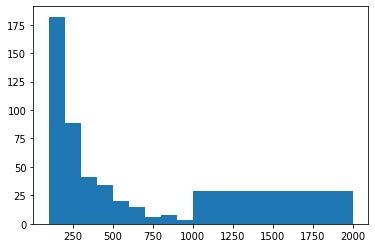

In [ ]:
plt.hist(relevant_lengths, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
print('Relevants')
print('mean: {}, median: {}, std: {}'.format(np.mean(relevant_lengths), np.median(relevant_lengths), np.std(relevant_lengths)))

Predicted Irrelevants
mean: 109.19864176570458, median: 70.0, std: 122.65414928861468


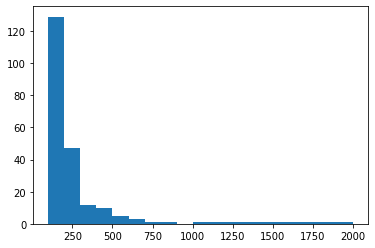

In [ ]:
relevant_lengths, irrelevant_lengths = [], []
for idx in range(len(labels)):
    if TP[idx] or FP[idx]:
        irrelevant_lengths.append(len(testset[idx][1]))
    else:
        relevant_lengths.append(len(testset[idx][1]))
plt.hist(irrelevant_lengths, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
print('Predicted Irrelevants')
print('mean: {}, median: {}, std: {}'.format(np.mean(irrelevant_lengths), np.median(irrelevant_lengths), np.std(irrelevant_lengths)))

Predicted Relevants
mean: 351.12038834951454, median: 197.0, std: 459.53402007221695


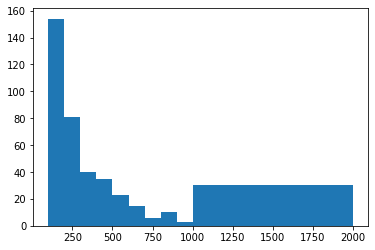

In [ ]:
plt.hist(relevant_lengths, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
print('Predicted Relevants')
print('mean: {}, median: {}, std: {}'.format(np.mean(relevant_lengths), np.median(relevant_lengths), np.std(relevant_lengths)))